# AutoMPC Demo

Welcome!  This notebook demonstrates the core features of AutoMPC.  We will use the Cart-Pole swing-up task as an example, and we will tune an MPC pipeline consisting of a multi-layer perception (MLP) system ID model and an iLQR optimizer.

## Set-Up

To begin, we need an input dataset and specifications for the system and task.  The `benchmarks` module provides these for a few example systems.

In [1]:
import os
os.chdir("..")
import autompc as ampc
import numpy as np
from autompc.benchmarks import CartpoleSwingupBenchmark

benchmark = CartpoleSwingupBenchmark()


# Get system and task specification
system = benchmark.system
task   = benchmark.task

# Generate benchmark dataset
trajs = benchmark.gen_trajs(seed=100, n_trajs=10, traj_len=200)

Next, we need to declare our MPC pipeline.  The following code initializes a pipeline with a MLP system ID model, a quadratic objective function, and and an iLQR optimizer.

In [2]:
from autompc.sysid import MLPFactory
from autompc.control import IterativeLQRFactory
from autompc.costs import QuadCostFactory

model_factory = MLPFactory(system)
ctrlr_factory = IterativeLQRFactory(system)
cost_factory  = QuadCostFactory(system)

pipeline = ampc.Pipeline(system, model_factory, ctrlr_factory, cost_factory)

We can view the joint configuration space of the pipeline

In [3]:
pipeline.get_configuration_space()

Configuration space object:
  Hyperparameters:
    _cost:dx_F, Type: UniformFloat, Range: [0.001, 10000.0], Default: 1.0, on log-scale
    _cost:dx_Q, Type: UniformFloat, Range: [0.001, 10000.0], Default: 1.0, on log-scale
    _cost:omega_F, Type: UniformFloat, Range: [0.001, 10000.0], Default: 1.0, on log-scale
    _cost:omega_Q, Type: UniformFloat, Range: [0.001, 10000.0], Default: 1.0, on log-scale
    _cost:theta_F, Type: UniformFloat, Range: [0.001, 10000.0], Default: 1.0, on log-scale
    _cost:theta_Q, Type: UniformFloat, Range: [0.001, 10000.0], Default: 1.0, on log-scale
    _cost:u_R, Type: UniformFloat, Range: [0.001, 10000.0], Default: 1.0, on log-scale
    _cost:x_F, Type: UniformFloat, Range: [0.001, 10000.0], Default: 1.0, on log-scale
    _cost:x_Q, Type: UniformFloat, Range: [0.001, 10000.0], Default: 1.0, on log-scale
    _ctrlr:horizon, Type: UniformInteger, Range: [5, 25], Default: 20
    _model:hidden_size_1, Type: UniformInteger, Range: [16, 256], Default: 32
    

## Tuning

Once we have initialized the pipeline and its factories, it is straightforward to set up a tuner to search the configuration space.  Here we use an MLP model for the surrogate model.  This is an example of full pipeline which searches the configuration space of all pipeline components simultaneously.

In [4]:
from autompc.tuning import PipelineTuner

tuner = PipelineTuner(surrogate_factory=MLPFactory(system), surrogate_split=0.5)

controller, tune_result = tuner.run(pipeline, task, trajs, n_iters=5, rng=np.random.default_rng(100), 
                                   truedyn=benchmark.dynamics)

/usr/lib/python3/dist-packages/pyparsing.py:1745: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/william/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Training surrogate model...
use_cuda=True
MLP Using Cuda
100%|██████████| 50/50 [00:01<00:00, 27.25it/s]

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2021-04-25_03:23:08_204367
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.sobol_design.SobolDesign:Running initial design for 1 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent



use_cuda=True
MLP Using Cuda
100%|██████████| 50/50 [00:04<00:00, 10.62it/s]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:10<00:00, 18.29it/s]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:07<00:00, 25.90it/s]

INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 200.0000



use_cuda=True
MLP Using Cuda
100%|██████████| 50/50 [00:04<00:00, 10.62it/s]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:21<00:00,  9.43it/s]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:35<00:00,  5.52it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 84.853264 sec, available: 0.000010 sec)



use_cuda=True
MLP Using Cuda
100%|██████████| 50/50 [00:03<00:00, 13.30it/s]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:15<00:00, 12.61it/s]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:21<00:00,  9.27it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 40.875212 sec, available: 0.000010 sec)



use_cuda=True
MLP Using Cuda
100%|██████████| 50/50 [00:04<00:00, 10.53it/s]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:52<00:00,  3.75it/s]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:58<00:00,  3.41it/s]

INFO:smac.intensification.intensification.Intensifier:Challenger (198.0000) is better than incumbent (200.0000) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  _cost:dx_F : 3.1622776601683813 -> 4.2871852816796885
INFO:smac.intensification.intensification.Intensifier:  _cost:dx_Q : 3.1622776601683813 -> 1.7916719007884376
INFO:smac.intensification.intensification.Intensifier:  _cost:omega_F : 3.1622776601683813 -> 18.65823651695353
INFO:smac.intensification.intensification.Intensifier:  _cost:omega_Q : 3.1622776601683813 -> 0.02484526551383647
INFO:smac.intensification.intensification.Intensifier:  _cost:theta_F : 3.1622776601683813 -> 1520.464258361176
INFO:smac.intensification.intensification.Intensifier:  _cost:theta_Q : 3.1622776601683813 -> 790.0558149344749
INFO:smac.intensification.intensification.Intensifier:  _cost:u_R : 3.1622776601683813 -> 0.5487898169767764
INFO:smac.intensificat


use_cuda=True
MLP Using Cuda
100%|██████████| 50/50 [00:05<00:00,  8.34it/s]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:33<00:00,  2.12it/s]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:16<00:00,  2.60it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 175.741013 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 1
INFO:smac.stats.stats.Stats:#Submitted target algorithm runs: 5 / 5.0
INFO:smac.stats.stats.Stats:#Finished target algorithm runs: 5 / 5.0
INFO:smac.stats.stats.Stats:#Configurations: 5
INFO:smac.stats.stats.Stats:Used wallclock time: 421.31 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 417.15 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Final Incumbent: Configuration:
  _cost:dx_F, Value: 4.2871852816796885
  _cost:dx_Q, Value: 1.7916719007884376
  _cost:omega_F, Value: 18.65823651695353
  _cost:omega_Q, Value: 0.02484526551383647
  _cost:theta_F,


use_cuda=True
MLP Using Cuda
100%|██████████| 50/50 [00:04<00:00, 10.64it/s]


It is then easy to plot the curve from the tuning result.

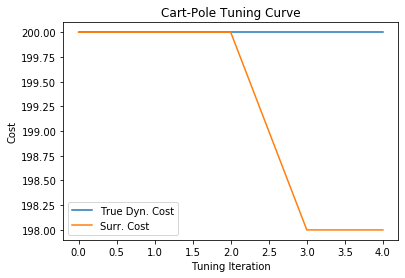

In [5]:
from autompc.graphs import TuningCurveGraph
import matplotlib.pyplot as plt

graph = TuningCurveGraph()

fig = plt.figure()      
ax = fig.gca()
graph(ax, tune_result)
ax.set_title("Cart-Pole Tuning Curve")
plt.show()

## Decoupled Tuning

The above examples is full pipeline tuning, which searches the configuration space of all components simultaneously.  Alternatively, we can take a decoupled tuning approach, where the model is first tuned based on prediction accuracy, then the objective function and optimizer are tuned.

First, we must tune the model

In [6]:
from autompc.tuning import ModelTuner
from autompc.evaluation import HoldoutModelEvaluator

model_evaluator = HoldoutModelEvaluator(holdout_prop=0.25, metric="rmse", trajs=trajs, system=system,
                                       rng=np.random.default_rng(100))
model_tuner = ModelTuner(system, model_evaluator)
model_tuner.add_model_factory(model_factory)

model, model_tune_result = model_tuner.run(rng=np.random.default_rng(100), n_iters=2)

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2021-04-25_03:30:14_417186
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.sobol_design.SobolDesign:Running initial design for 1 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent


Evaluating cfg:
Configuration:
  _MLP:hidden_size_1, Value: 136
  _MLP:hidden_size_2, Value: 136
  _MLP:hidden_size_3, Value: 136
  _MLP:lr, Value: 0.003162277660168379
  _MLP:n_hidden_layers, Value: '3'
  _MLP:nonlintype, Value: 'sigmoid'
  model, Value: 'MLP'

use_cuda=True
MLP Using Cuda
100%|██████████| 50/50 [00:03<00:00, 13.86it/s]

INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.6046



Evaluating cfg:
Configuration:
  _MLP:hidden_size_1, Value: 163
  _MLP:lr, Value: 0.0001970689002759384
  _MLP:n_hidden_layers, Value: '1'
  _MLP:nonlintype, Value: 'selu'
  model, Value: 'MLP'

use_cuda=True
MLP Using Cuda
100%|██████████| 50/50 [00:01<00:00, 27.96it/s]

INFO:smac.intensification.intensification.Intensifier:Challenger (0.3535) is better than incumbent (0.6046) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  _MLP:hidden_size_1 : 136 -> 163
INFO:smac.intensification.intensification.Intensifier:  _MLP:lr : 0.003162277660168379 -> 0.0001970689002759384
INFO:smac.intensification.intensification.Intensifier:  _MLP:n_hidden_layers : '3' -> '1'
INFO:smac.intensification.intensification.Intensifier:  _MLP:nonlintype : 'sigmoid' -> 'selu'
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 5.408179 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 1
INFO:smac.stats.stats.Stats:#Submitted target algorithm runs: 2 / 2.0
INFO:smac.stats.stats.Sta

INFO:smac.stats.stats.Stats:Used wallclock time: 5.90 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 5.41 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Final Incumbent: Configuration:
  _MLP:hidden_size_1, Value: 163
  _MLP:lr, Value: 0.0001970689002759384
  _MLP:n_hidden_layers, Value: '1'
  _MLP:nonlintype, Value: 'selu'
  model, Value: 'MLP'

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Estimated cost of incumbent: 0.353524


use_cuda=True
MLP Using Cuda
100%|██████████| 50/50 [00:02<00:00, 21.41it/s]


Now that we have tuned the model, we can create a pipeline with the pre-tuned model, and then run pipeline tuning.

In [7]:
pipeline_fixed_model = ampc.Pipeline(system, model, ctrlr_factory, cost_factory)
controller2, tune_result2 = tuner.run(pipeline, task, trajs, n_iters=100)   

TypeError: run() missing 1 required positional argument: 'rng'